## DeepWave 

For now I am only interested in ensuring that the model architecture and pipeline can be deployed; meaning,
the input, in-between, and output dimentions of the data structures is correct and as expected.

What's new in this implementation?
- A PyTorch-based architecture of deepwave

Main building blocks:
- SphericalChebConv: Spherical Chebyshev graph convolutions
- SphericalConvLayer: Spherical convolution with ReLu activation
- BackProjLayer: project correlation matrix into image form (intensity map form)
- DeepWave: the actual model architecture

DeepWave architecture in a nutshell for trainable parameters mu, D, tau:
```
laplacian(R, depth)
kernel_size
BackProjLayer(mu, D, tau) 
SphericalConvLayer(Nch, Npx, laplacian, chev_kernel_size)
SphericalConvLayer(Nch, Npx, laplacian, chev_kernel_size)
SphericalConvLayer(Nch, Npx, laplacian, chev_kernel_size)
SphericalConvLayer(Nch, Npx, laplacian, chev_kernel_size)
SphericalConvLayer(Nch, Npx, laplacian, chev_kernel_size)
```


Input requimerements:
- S: a visibility matrix (correlation matrix in frequency domain of the 48 ch in the mic array)
- I_prev: a previous intensity map (or intial guess), which is the networks starting point.

What is next?
- Work actual training: using pre-extracted data with DeepWave's data extractors
- Work on integrating a data loader implemented with PyTorch

In [1021]:
# TODO:
# Under DeepWave, initialize a single GraphConv layer and use it N_layer times
# Refactor classes and initializers

In [1]:
# TODO: cleanup unnecesary imports
import argparse
import logging
import pathlib
import sys
import os

import pandas as pd
import numpy as np
import scipy.constants as constants
import scipy.io.wavfile as wavfile
import scipy.linalg as linalg
import scipy.spatial as spatial
import skimage.util as skutil
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg
import scipy.spatial as spatial

In [2]:
import math
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
from scipy.sparse import coo_matrix
from pygsp.graphs import Graph

In [4]:
# Note: deepwave.nn and deepwave.nn.crnn only imported for data loader purposes.
import deepwave.nn as nn
import deepwave.nn.crnn as crnn

In [88]:
# The graph laplacian can be used in the same way as we are doing

def scipy_csr_to_sparse_tensor(csr_mat):
    """Convert scipy csr to sparse pytorch tensor.
    Args:
        csr_mat (csr_matrix): The sparse scipy matrix.
    Returns:
        sparse_tensor :obj:`torch.sparse.DoubleTensor`: The sparse torch matrix.
    """
    coo = coo_matrix(csr_mat)
    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    idx = torch.LongTensor(indices)
    vals = torch.DoubleTensor(values)
    shape = coo.shape
    sparse_tensor = torch.sparse.DoubleTensor(idx, vals, torch.Size(shape))
    sparse_tensor = sparse_tensor.coalesce()
    return sparse_tensor


def prepare_laplacian(laplacian):
    """Prepare a graph Laplacian to be fed to a graph convolutional layer.
    """
    def estimate_lmax(laplacian, tol=5e-3):
        """Estimate the largest eigenvalue of an operator.
        """
        lmax = sp.linalg.eigsh(laplacian, k=1, tol=tol, ncv=min(laplacian.shape[0], 10), return_eigenvectors=False)
        lmax = lmax[0]
        lmax *= 1 + 2 * tol  # Be robust to errors.
        return lmax

    def scale_operator(L, lmax, scale=1):
        """Scale the eigenvalues from [0, lmax] to [-scale, scale].
        """
        I = sp.identity(L.shape[0], format=L.format, dtype=L.dtype)
        L *= 2 * scale / lmax
        L -= I
        return L

    lmax = estimate_lmax(laplacian)
    laplacian = scale_operator(laplacian, lmax)
    laplacian = scipy_csr_to_sparse_tensor(laplacian)
    return laplacian


def cvxhull_graph(R: np.ndarray, cheb_normalized: bool = True, compute_differential_operator: bool = True):

    r"""
    Build the convex hull graph of a point set in :math:`\mathbb{R}^3`.

    The graph edges have exponential-decay weighting.

    Definitions of the graph Laplacians:

    .. math::

        L     = I - D^{-1/2} W D^{-1/2},\qquad        L_{n} = (2 / \mu_{\max}) L - I

    Parameters
    ----------
    R : :py:class:`~numpy.ndarray`
        (N,3) Cartesian coordinates of point set with size N. All points must be **distinct**.
    cheb_normalized : bool
        Rescale Laplacian spectrum to [-1, 1].
    compute_differential_operator : bool
        Computes the graph gradient.

    Returns
    -------
    G : :py:class:`~pygsp.graphs.Graph`
        If ``cheb_normalized = True``, ``G.Ln`` is created (Chebyshev Laplacian :math:`L_{n}` above)
        If ``compute_differential_operator = True``, ``G.D`` is created and contains the gradient.
    rho : float
        Scale parameter :math:`\rho` corresponding to the average distance of a point
        on the graph to its nearest neighbors.

    Examples
    --------

    .. plot::

        import numpy as np
        from pycgsp.graph import cvxhull_graph
        from pygsp.plotting import plot_graph
        theta, phi = np.linspace(0,np.pi,6, endpoint=False)[1:], np.linspace(0,2*np.pi,9, endpoint=False)
        theta, phi = np.meshgrid(theta, phi)
        x,y,z = np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)
        R = np.stack((x.flatten(), y.flatten(), z.flatten()), axis=-1)
        G, _ = cvxhull_graph(R)
        plot_graph(G)

    Warnings
    --------
    In the newest version of PyGSP (> 0.5.1) the convention is changed: ``Graph.D`` is the divergence operator and
    ``Graph.D.transpose()`` the gradient (see routine `Graph.compute_differential_operator <https://pygsp.readthedocs.io/en/latest/reference/graphs.html#pygsp.graphs.Graph.compute_differential_operator>`_). The code should be adapted when this new version is released.

    """

    # Form convex hull to extract nearest neighbors. Each row in
    # cvx_hull.simplices is a triangle of connected points.
    cvx_hull = spatial.ConvexHull(R.T)
    cols = np.roll(cvx_hull.simplices, shift=1, axis=-1).reshape(-1)
    rows = cvx_hull.simplices.reshape(-1)

    # Form sparse affinity matrix from extracted pairs
    W = sp.coo_matrix((cols * 0 + 1, (rows, cols)),
                      shape=(cvx_hull.vertices.size, cvx_hull.vertices.size))
    # Symmetrize the matrix to obtain an undirected graph.
    extended_row = np.concatenate([W.row, W.col])
    extended_col = np.concatenate([W.col, W.row])
    W.row, W.col = extended_row, extended_col
    W.data = np.concatenate([W.data, W.data])
    W = W.tocsr().tocoo()  # Delete potential duplicate pairs

    # Weight matrix elements according to the exponential kernel
    distance = linalg.norm(cvx_hull.points[W.row, :] -
                           cvx_hull.points[W.col, :], axis=-1)
    rho = np.mean(distance)
    W.data = np.exp(- (distance / rho) ** 2)
    W = W.tocsc()

    G = _graph_laplacian(W, R, compute_differential_operator=compute_differential_operator,
                         cheb_normalized=cheb_normalized)
    return G, rho

def _graph_laplacian(W, R, compute_differential_operator=False, cheb_normalized=False):
    # Form Graph Laplacian
    G = Graph(W, gtype='undirected', lap_type='normalized', coords=R)
    G.compute_laplacian(lap_type='normalized')  # Stored in G.L, sparse matrix, csc ordering
    if compute_differential_operator is True:
        G.compute_differential_operator()  # stored in G.D, also accessible via G.grad() or G.div() (for the adjoint).
    else:
        pass

    if cheb_normalized:
        D_max = splinalg.eigsh(G.L, k=1, return_eigenvectors=False)
        Ln = (2 / D_max[0]) * G.L - sp.identity(W.shape[0], dtype=np.float64, format='csc')
        G.Ln = Ln
    else:
        pass
    return G
    
def laplacian_exp(R, depth):
    """Get the icosahedron laplacian list for a certain depth.
    Args:
        R : :py:class:`~numpy.ndarray`
        (N,3) Cartesian coordinates of point set with size N. All points must be **distinct**.
    Returns:
        laplacian, rho: laplacian and laplacian order
    """
    laps = []
    for i in range(depth):
        G, rho = cvxhull_graph(R)
        laplacian = prepare_laplacian(G.L)
        laps.append(laplacian)
    return laps[::-1], rho

In [104]:
def cheb_conv(laplacian, inputs, weight):
    """Chebyshev convolution.
    Args:
        laplacian (:obj:`torch.sparse.Tensor`): The laplacian corresponding to the current sampling of the sphere.
        inputs (:obj:`torch.Tensor`): The current input data being forwarded. (Nsamps, Npx)
        weight (:obj:`torch.Tensor`): The weights of the current layer. (K,)
    Returns:
        :obj:`torch.Tensor`: Inputs after applying Chebyshev convolution. (Nsamps, Npx)  
    """
    K = weight.shape[0]
    was_1d = (inputs.ndim == 1)
    if was_1d:
        inputs = inputs.unsqueeze(0)
    N_sample, Npx = inputs.shape[0], inputs.shape[1]

    x0 = inputs.T # (Nsamps, Npx).T -> (Npx, Nsamps)
    inputs = x0.T.unsqueeze(0) # (1, Npx, Nsamps)
    x1 = torch.sparse.mm(laplacian, x0) # (Npx, Npx) x (Npx, Nsamps) -> (Npx, Nsamps)
    inputs = torch.cat((inputs, x1.T.unsqueeze(0)), 0) # (1, Nsamps, Npx) + (1, Nsamps, Npx) = (2*Nsamps, Npx)
    for _ in range(1, K - 1):
        x2 = 2 * torch.sparse.mm(laplacian, x1) - x0 # (Npx, Npx) x (Npx, Nsamps) - (Npx, Nsamps) = (Npx, Nsamps)
        inputs = torch.cat((inputs, x2.T.unsqueeze(0)), 0)  # (ki, Nsamps, Npx) + (1, Nsamps, Npx) 
        x0, x1 = x1, x2 # (Npx, Nsamps), (Npx, Nsamps)
    inputs = inputs.permute(1, 2, 0).contiguous()  # (K, Nsamps, Npx)
    inputs = inputs.view([N_sample*Npx, K])  # (Nsamps*Npx, K)
    inputs = inputs.matmul(weight)  # (Nsamps*Npx, K) x (K,) -> (Nsamps*Npx,)
    inputs = inputs.view([N_sample, Npx]) # (Nsamps, Npx)                     
    return inputs

class ChebConv(torch.nn.Module):
    """Graph convolutional layer.
    """

    def __init__(self, in_channels, out_channels, kernel_size, weight=None, bias=False, conv=cheb_conv):
        """Initialize the Chebyshev layer.
        Args:
            in_channels (int): Number of channels/features in the input graph.
            out_channels (int): Number of channels/features in the output graph.
            kernel_size (int): Number of trainable parameters per filter, which is also the size of the convolutional kernel.
                                The order of the Chebyshev polynomials is kernel_size - 1.
            bias (bool): Whether to add a bias term.
            conv (callable): Function which will perform the actual convolution.
        """
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self._conv = conv
        if weight is None:
            self.weight = torch.nn.Parameter(torch.DoubleTensor(*shape))
            self.weight.data.normal_(0, std)
        else:
            self.weight = weight
#         shape = (kernel_size,)
#         self.weight = torch.nn.Parameter(torch.DoubleTensor(*shape))

        if bias:
            self.bias = torch.nn.Parameter(torch.DoubleTensor(out_channels))
        else:
            self.register_parameter("bias", None)

        self.kaiming_initialization()

    def kaiming_initialization(self):
        """Initialize weights and bias.
        """
#         std = math.sqrt(2 / (self.in_channels * self.kernel_size))
#         self.weight.data.normal_(0, std)
        if self.bias is not None:
            self.bias.data.fill_(0.00001)

    def forward(self, laplacian, inputs):
        """Forward graph convolution.
        Args:
            laplacian (:obj:`torch.sparse.Tensor`): The laplacian corresponding to the current sampling of the sphere.
            inputs (:obj:`torch.Tensor`): The current input data being forwarded.
        Returns:
            :obj:`torch.Tensor`: The convoluted inputs.
        """
        outputs = self._conv(laplacian, inputs, self.weight)
        if self.bias is not None:
            outputs += self.bias
        return outputs
    
class SphericalChebConv(torch.nn.Module):
    """Building Block with a Chebyshev Convolution.
    """

    def __init__(self, in_channels, out_channels, lap, kernel_size, weight):
        """Initialization.
        Args:
            in_channels (int): initial number of channels
            out_channels (int): output number of channels
            lap (:obj:`torch.sparse.FloatTensor`): laplacian
            kernel_size (int): polynomial degree. Defaults to 3.
        """
        super().__init__()
        self.register_buffer("laplacian", lap)
        self.chebconv = ChebConv(in_channels, out_channels, kernel_size, weight)

    def state_dict(self, *args, **kwargs):
        """! WARNING !
        This function overrides the state dict in order to be able to save the model.
        This can be removed as soon as saving sparse matrices has been added to Pytorch.
        """
        state_dict = super().state_dict(*args, **kwargs)
        del_keys = []
        for key in state_dict:
            if key.endswith("laplacian"):
                del_keys.append(key)
        for key in del_keys:
            del state_dict[key]
        return state_dict

    def forward(self, x):
        """Forward pass.
        Args:
            x (:obj:`torch.tensor`): input [batch x vertices x channels/features]
        Returns:
            :obj:`torch.tensor`: output [batch x vertices x channels/features]
        """
        x = self.chebconv(self.laplacian, x)
        return x


In [105]:
class ReTanh(torch.nn.Module):
    '''
    Rectified Hyperbolic Tangent
    '''
    #the init method takes the parameter:
    def __init__(self, alpha=1.000000):
        super().__init__()
        self.alpha = alpha

    #the forward calls it:
    def forward(self, x):
        beta = self.alpha / torch.tanh(torch.ones(1, dtype=torch.float64))
        return torch.fmax(torch.zeros(x.shape, dtype=torch.float64), beta * torch.tanh(x))

In [138]:
class SphericalConvLayer(torch.nn.Module):
    """Building Block with a Chebyshev Convolution, and ReLu activation.
    """

    def __init__(self, in_channels, out_channels, lap, kernel_size, weight):
        """Initialization.
        Args:
            in_channels (int): initial number of channels.
            out_channels (int): output number of channels.
            lap (:obj:`torch.sparse.FloatTensor`): laplacian.
            kernel_size (int, optional): polynomial degree. Defaults to 3.
        """
        super().__init__()
        self.spherical_cheb = SphericalChebConv(in_channels, out_channels, lap, kernel_size, weight)
#         self.retanh = ReTanh(alpha=1.000000)
        
    def forward(self, x):
        """Forward Pass.
        Args:
            x (:obj:`torch.tensor`): input [batch x vertices x channels/features]
        Returns:
            :obj:`torch.tensor`: output [batch x vertices x channels/features]
        """
        x = self.spherical_cheb(x)
#         x = self.retanh(x)
#         x = F.selu(x)
#         x = F.relu(x)
        return x

In [139]:
class BackProjLayer(torch.nn.Module):
    """Spherical Convolutional Neural Netork.
    """

    def __init__(self, K, Nch, Npx, mu=None, tau=None, D=None):
        """Initialization.
        Args:
            mu: (K,) where K = filter order
            tau: (Npx,)
            D: (Nch, Npx)
        """
        super().__init__()
        if tau is None: # or tau or D
#             self.mu = torch.nn.Parameter(torch.empty((K), dtype=torch.float64))
            self.tau = torch.nn.Parameter(torch.empty((Npx), dtype=torch.float64))
            self.D = torch.nn.Parameter(torch.empty((Nch, Npx), dtype=torch.complex128))
            self.reset_parameters()
        else:
#             self.mu = mu
            self.tau = tau
            self.D = D
            

    def reset_parameters(self):
        std = 1 # TODO: set a different std value?
#         self.mu.data.normal_(0, std) * 1.0e-5
        self.tau.data.normal_(0, std) * 1.0e-5
        self.D.data.normal_(0, std) * 1.0e-5

    def forward(self, S):
        """Forward Pass.
        Args:
            S (:obj:`torch.Tensor`): input to be forwarded. (N_sample, Npx)
        Returns:
            :obj:`torch.Tensor`: output: (N_sample, Npx)
        """
        N_sample, N_px = S.shape[0], self.tau.shape[0]
        y = torch.zeros((N_sample, N_px))
        for i in range(N_sample): # Broadcasting solution is slower
            Ds, Vs = torch.linalg.eigh(S[i]) # (Nch, Nch), (Nch, Nch) # S[i] before
            idx = Ds > 0  # To avoid np.sqrt() issues.
            Ds, Vs = Ds[idx], Vs[:, idx]
            y[i] = torch.linalg.norm(self.D.conj().T @ (Vs * torch.sqrt(Ds)), axis=1) ** 2 # (Npx, Nch) dot ((Nch, Nch) * (Nch, Nch))
        y -= self.tau[0]
        return y

In [148]:
# Write this class where we will be doing the forward pass over the L different layers in the network
class DeepWave(torch.nn.Module):
    """DeepWave: real-time recurrent neural network for acoustic imaging.
    """

    def __init__(self, R, kernel_size, Nch, Npx, I_init=None, batch_size=1, depth=5, pretr_params=None):
        """Initialization.
        Args:
            laps (list): List of laplacians.
            kernel_size (int): polynomial degree.
        """
        super().__init__()
        if I_init is None:
            self.I = torch.nn.Parameter(torch.empty(Npx, dtype=torch.float64))
            self.reset_parameters()
        else:
            self.I = I_init
        
        self.laps, self.rho = laplacian_exp(R, depth)
        if pretr_params:
            self.y_backproj = BackProjLayer(kernel_size, Nch, Npx) # TODO: sanity check by comparing with numpy implementation
        else:
            self.y_backproj = BackProjLayer(kernel_size, Nch, Npx, mu=pretr_params['mu'], tau=pretr_params['tau'], D=pretr_params['D'])
        self.enc_l4 = SphericalConvLayer(Nch, Npx, self.laps[4], kernel_size, weight=pretr_params['mu'])
        self.rtanh4 = ReTanh(alpha=1.000000)
        self.enc_l3 = SphericalConvLayer(Nch, Npx, self.laps[3], kernel_size, weight=pretr_params['mu'])
        self.rtanh3 = ReTanh(alpha=1.000000)
        self.enc_l2 = SphericalConvLayer(Nch, Npx, self.laps[2], kernel_size, weight=pretr_params['mu'])
        self.rtanh2 = ReTanh(alpha=1.000000)
        self.enc_l1 = SphericalConvLayer(Nch, Npx, self.laps[1], kernel_size, weight=pretr_params['mu'])
        self.rtanh1 = ReTanh(alpha=1.000000)
        self.enc_l0 = SphericalConvLayer(Nch, Npx, self.laps[0], kernel_size, weight=pretr_params['mu'])
        self.rtanh0 = ReTanh(alpha=1.000000)

    def reset_parameters(self):
        std = 1 # TODO: set a different std value?
        self.I.data.random_(0, 1) * 0
        
    def forward(self, S):
        """Forward Pass.
        Args:
            x (:obj:`torch.Tensor`): input [batch x vertices x channels/features]
        Returns:
            x_enc* :obj: `torch.Tensor`: output [batch x vertices x channels/features]
        """
        y_proj = self.y_backproj(S) # (N_sample, Npx)
        x_enc4 = self.enc_l4(self.I) #self.I) # (N_sample, Npx) 
        x_enc4 = x_enc4.add(y_proj)
        x_enc4 = self.rtanh4(x_enc4)
        x_enc3 = self.enc_l3(x_enc4)
        x_enc3 = x_enc3.add(y_proj)
        x_enc3 = self.rtanh3(x_enc3)
        x_enc2 = self.enc_l2(x_enc3)
        x_enc2 = x_enc2.add(y_proj)
        x_enc2 = self.rtanh2(x_enc2)
        x_enc1 = self.enc_l1(x_enc2)
        x_enc1 = x_enc1.add(y_proj)
        x_enc1 = self.rtanh1(x_enc1)
        x_enc0 = self.enc_l0(x_enc1)
        x_enc0 = x_enc0.add(y_proj)
        x_enc0 = self.rtanh0(x_enc0)
        out = x_enc0

        return out
    

In [149]:
# Utility functions

def estimate_chevpol_order(XYZ, rho, wl, eps):
    r"""
    Compute order of polynomial filter to approximate asymptotic
    point-spread function on \cS^{2}.

    Parameters
    ----------
    XYZ : :py:class:`~numpy.ndarray`
        (3, N_antenna) Cartesian instrument coordinates.
    rho : float
        Scale parameter \rho corresponding to the average distance of a point
        on the graph to its nearest neighbor.
        Output of :py:func:`~deepwave.tools.math.graph.laplacian_exp`.
    wl : float
        Wavelength of observations [m].
    eps : float
        Ratio in (0, 1).
        Ensures all PSF magnitudes lower than `max(PSF)*eps` past the main
        lobe are clipped at 0.

    Returns
    -------
    K : int
        Order of polynomial filter.
    """
    XYZ = XYZ / wl
    XYZ_centroid = np.mean(XYZ, axis=1, keepdims=True)
    XYZ_radius = np.mean(linalg.norm(XYZ - XYZ_centroid, axis=0))

    theta = np.linspace(0, np.pi, 1000)
    f = 20 * np.log10(np.abs(np.sinc(theta / np.pi)))
    eps_dB = 10 * np.log10(eps)
    theta_max = np.max(theta[f >= eps_dB])

    beam_width = theta_max / (2 * np.pi * XYZ_radius)
    K = np.sqrt(2 - 2 * np.cos(beam_width)) / rho
    K = int(np.ceil(K))
    return K

def steering_operator(XYZ, R, wl):
    '''
    XYZ : :py:class:`~numpy.ndarray`
        (3, N_antenna) Cartesian array geometry.
    R : :py:class:`~numpy.ndarray`
        (3, N_px) Cartesian grid points in :math:`\mathbb{S}^{2}`.
    wl : float
        Wavelength [m].
    return: steering matrix
    '''
    scale = 2 * np.pi / wl
    A = np.exp((-1j * scale * XYZ.T) @ R)
    return A

def eighMax(A):
    r"""
    Evaluate :math:`\mu_{\max}(\bbB)` with
    :math:
    B = (\overline{\bbA} \circ \bbA)^{H} (\overline{\bbA} \circ \bbA)
    Uses a matrix-free formulation of the Lanczos algorithm.
    Parameters
    ----------
    A : :py:class:`~numpy.ndarray`
        (M, N) array.

    Returns
    -------
    D_max : float
        Leading eigenvalue of `B`.
    """
    if A.ndim != 2:
        raise ValueError('Parameter[A] has wrong dimensions.')

    def matvec(v):
        r"""
        Parameters
        ----------
        v : :py:class:`~numpy.ndarray`
            (N,) or (N, 1) array

        Returns
        -------
        w : :py:class:`~numpy.ndarray`
            (N,) array containing :math:`\bbB \bbv`
        """
        v = v.reshape(-1)

        C = (A * v) @ A.conj().T
        D = C @ A
        w = np.sum(A.conj() * D, axis=0).real
        return w

    M, N = A.shape
    B = splinalg.LinearOperator(shape=(N, N),
                                matvec=matvec,
                                dtype=np.float64)
    D_max = splinalg.eigsh(B, k=1, which='LM', return_eigenvectors=False)
    return D_max[0]

In [150]:
###### Plotting Utils #######
# Plotting APGD Intensity field: we actually cannot plot since this is training done one freq band at a time.
import matplotlib.pyplot as plt
import imot_tools.math.sphere.transform as transform
import astropy.coordinates as coord
import astropy.units as u
import collections.abc as abc

from matplotlib.colors import LinearSegmentedColormap

def wrapped_rad2deg(lat_r, lon_r):
    """
    Equatorial coordinate [rad] -> [deg] unit conversion.
    Output longitude guaranteed to lie in [-180, 180) [deg].
    """
    lat_d = coord.Angle(lat_r * u.rad).to_value(u.deg)
    lon_d = coord.Angle(lon_r * u.rad).wrap_at(180 * u.deg).to_value(u.deg)
    return lat_d, lon_d

def cmap_from_list(name, colors, N=256, gamma=1.0):
    """
    Parameters
    ----------
    name : str
    colors :
        * a list of (value, color) tuples; or
        * list of color strings
    N : int
        Number of RGB quantization levels.
    gamma : float
        Something?

    Returns
    -------
    cmap : :py:class:`matplotlib.colors.LinearSegmentedColormap`
    """
    from collections import Sized
    import matplotlib.colors

    print(colors.shape)
    colors_len = len(colors)
    colors = np.append(colors, np.zeros(colors_len*2))
    colors = colors.reshape((3, colors_len))
    colors = colors.T
    if not isinstance(colors, abc.Iterable):
        raise ValueError('colors must be iterable')

    if (isinstance(colors[0], Sized) and
        (len(colors[0]) == 2) and
        (not isinstance(colors[0], str))):  # List of value, color pairs
        vals, colors = zip(*colors)
    else:
        vals = np.linspace(0, 1, len(colors))

    cdict = dict(red=[], green=[], blue=[], alpha=[])
    for val, color in zip(vals, colors):
        r, g, b, a = matplotlib.colors.to_rgba(color)
        cdict['red'].append((val, r, r))
        cdict['green'].append((val, g, g))
        cdict['blue'].append((val, b, b))
        cdict['alpha'].append((val, a, a))

    return matplotlib.colors.LinearSegmentedColormap(name, cdict, N, gamma)

def draw_map(I, R, lon_ticks, catalog=None, show_labels=False, show_axis=False):
    import mpl_toolkits.basemap as basemap
    import matplotlib.tri as tri

    _, R_el, R_az = transform.cart2eq(*R)
    R_el, R_az = wrapped_rad2deg(R_el, R_az)
    R_el_min, R_el_max = np.around([np.min(R_el), np.max(R_el)])
    R_az_min, R_az_max = np.around([np.min(R_az), np.max(R_az)])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    bm = basemap.Basemap(projection='mill',
                         llcrnrlat=R_el_min, urcrnrlat=R_el_max,
                         llcrnrlon=R_az_min, urcrnrlon=R_az_max,
                         resolution='c',
                         ax=ax)

    if show_axis:
        bm_labels = [1, 0, 0, 1]
    else:
        bm_labels = [0, 0, 0, 0]
    bm.drawparallels(np.linspace(R_el_min, R_el_max, 5),
                    color='w', dashes=[1, 0], labels=bm_labels, labelstyle='+/-',
                    textcolor='#565656', zorder=0, linewidth=2)
    bm.drawmeridians(lon_ticks,
                    color='w', dashes=[1, 0], labels=bm_labels, labelstyle='+/-',
                    textcolor='#565656', zorder=0, linewidth=2)

    if show_labels:
        ax.set_xlabel('Azimuth (degrees)', labelpad=20)
        ax.set_ylabel('Elevation (degrees)', labelpad=40)

    R_x, R_y = bm(R_az, R_el)
    triangulation = tri.Triangulation(R_x, R_y)

    N_px = len(I)
    min_val, max_val = I.min(), I.max()
    colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
    mycmap = cmap_from_list('mycmap', I/I.max(), N=N_px)
    colors_cmap = np.arange(N_px)
    ax.tripcolor(triangulation, colors_cmap, cmap=mycmap,
                 shading='gouraud', alpha=0.9, edgecolors='w', linewidth=0.1)

    if catalog is not None:
        _, sky_el, sky_az = transform.cart2eq(*catalog.xyz)
        sky_el, sky_az = wrapped_rad2deg(sky_el, sky_az)
        sky_x, sky_y = bm(sky_az, sky_el)
        ax.scatter(sky_x, sky_y, c='w', s=5)

    return fig, ax

## Load data using DeepWave's original data loader

Input requimerements:
- S: a visibility matrix (correlation matrix in frequency domain of the 48 ch in the mic array)
- I_prev: a previous intensity map (or intial guess), which is the networks starting point.

The above input requirements, for sake of a sanity check of the pipeline, are extracted via:
```
S, I, I_prev = sampler.decode(D[:])
```

In [12]:
# D = nn.DataSet.from_file("/Users/adrianromanguzman/Documents/repos/DeepWave/datasets/FRIDA/dataset/D_1_freq1_cold_singletrack.npz")
D = nn.DataSet.from_file("/home/asroman/repos/DeepWave/datasets/FRIDA/dataset/D_1-5_freq0_cold.npz")
# A = steering_operator(D.XYZ, D.R, D.wl)
# N_antenna, N_px = A.shape
# sampler = nn.Sampler(N_antenna, N_px)

# # Set optimization initial point.
# p_apgd, K = crnn.APGD_Parameter(D.XYZ, D.R, D.wl,
#                                 lambda_=np.median(D.lambda_),
#                                 gamma=D.gamma,
#                                 L=2 * eighMax(A),
#                                 eps=0.00000100)
# parameter = crnn.Parameter(N_antenna, N_px, K)
# p0 = p_apgd.copy()
# p_mu, p_D, p_tau = parameter.decode(p0)
# S, I, I_prev = sampler.decode(D[:])

In [151]:
Df = nn.DataSet.from_file("/home/asroman/repos/DeepWave/datasets/FRIDA/dataset/D_1-5_freq0_cold.npz") # Select 0th frequency
Pf = np.load("/home/asroman/repos/DeepWave/datasets/FRIDA/dataset/D_freq0_train.npz") # Select 0th trained frequency
N_antenna = Df.XYZ.shape[1]
N_px = Df.R.shape[1]
K = int(Pf['K'])
print("Num antenna:", N_antenna)
print("Filter Kth:", K)
parameter = crnn.Parameter(N_antenna, N_px, K)
sampler = Df.sampler()
p_opt = Pf['p_opt'][np.argmin(Pf['v_loss'])]
S, I, I_prev = sampler.decode(Df[0])
N_layer = Pf['N_layer']
print("Number of layers:", N_layer)
p_mu, p_D, p_tau = parameter.decode(p_opt) # Load trained parameters

Num antenna: 48
Filter Kth: 22
Number of layers: 5


In [152]:
print("p_mu info ", torch.from_numpy(p_mu).dtype, " ", torch.from_numpy(p_mu).shape)
print("p_D info ", torch.from_numpy(p_D).dtype, " ", torch.from_numpy(p_D).shape)
print("p_tau info ", torch.from_numpy(p_tau).dtype, " ", torch.from_numpy(p_tau).shape)

p_mu info  torch.float64   torch.Size([23])
p_D info  torch.complex128   torch.Size([48, 2234])
p_tau info  torch.float64   torch.Size([2234])


In [153]:
print("Input magnnitude (complex valued):")
print("min:", np.abs(S).min(), "max:", np.abs(S).max(), "mean",  np.abs(S).mean())
print("Output (gt labels):")
print("min:", I_prev.min(), "max:", I_prev.max(), "mean:", I_prev.mean())
print(S.mean())
# print(I.shape)
print(I_prev.shape)

Input magnnitude (complex valued):
min: 0.00023847094820290916 max: 0.2126937158622223 mean 0.030682125339952158
Output (gt labels):
min: 0.0 max: 0.0 mean: 0.0
(0.0018106669586314655+0j)
(2234,)


In [154]:
pretr_params = {"mu": torch.from_numpy(p_mu), 
                "tau": torch.from_numpy(p_tau),
                "D": torch.from_numpy(p_D)}
print(K)

22


In [155]:
# Nch, Npx = S.shape[1], I.shape[1]
# SS = torch.from_numpy(S)
# II_prev = torch.from_numpy(I_prev)
model = DeepWave(R=Df.R, kernel_size=K+1, Nch=N_antenna, Npx=N_px,
                 I_init=torch.from_numpy(I_prev), batch_size=1, depth=5, pretr_params=pretr_params)
print(model)

DeepWave(
  (y_backproj): BackProjLayer()
  (enc_l4): SphericalConvLayer(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
  )
  (rtanh4): ReTanh()
  (enc_l3): SphericalConvLayer(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
  )
  (rtanh3): ReTanh()
  (enc_l2): SphericalConvLayer(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
  )
  (rtanh2): ReTanh()
  (enc_l1): SphericalConvLayer(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
  )
  (rtanh1): ReTanh()
  (enc_l0): SphericalConvLayer(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
  )
  (rtanh0): ReTanh()
)


In [156]:
# Generated tesselation for Robinson projection 
arg_lonticks = np.linspace(-180, 180, 5)
R = Df.R
# Filter field to lie in specified interval
_, R_lat, R_lon = transform.cart2eq(*R)
_, R_lon_d = wrapped_rad2deg(R_lat, R_lon)
min_lon, max_lon = arg_lonticks.min(), arg_lonticks.max()
mask_lon = (min_lon <= R_lon_d) & (R_lon_d <= max_lon)
R_field = transform.eq2cart(1, R_lat[mask_lon], R_lon[mask_lon])

[6.54174772e-05 0.00000000e+00 0.00000000e+00 ... 4.07606944e-06
 0.00000000e+00 3.70807490e-05]
(2234,)


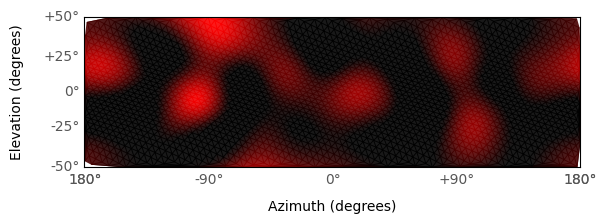

In [157]:
# Ground truth plot
I_rgb = I
print(I)
fig, ax = draw_map(I_rgb, R_field,
                   lon_ticks=arg_lonticks,
                   catalog=None,
                   show_labels=True,
                   show_axis=True)

tensor([[1.3020, 1.3128, 1.3130,  ..., 1.3130, 1.3130, 1.3130]],
       dtype=torch.float64, grad_fn=<FmaxBackward0>)
(2234,)
<class 'numpy.float64'>
(2234,)


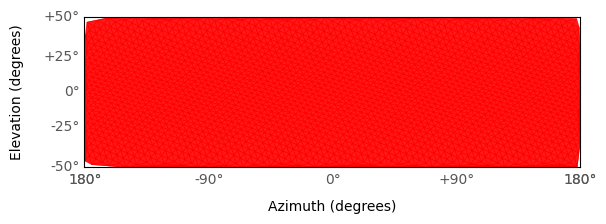

In [158]:
I_rgb_pred = model(torch.from_numpy(S).unsqueeze(0))
print(I_rgb_pred)
I_rgb_pred = I_rgb_pred.detach().numpy()[0,:]
print(I_rgb_pred.shape)
print(type(I_rgb_pred[0]))
fig, ax = draw_map(I_rgb_pred, R_field,
                   lon_ticks=arg_lonticks,
                   catalog=None,
                   show_labels=True,
                   show_axis=True)

In [69]:
total_params = sum(
    param.numel() for param in model.parameters()
)
total_params

123008

In [86]:
# Load training and validation datasets
### Dataset Preprocessing: drop all-0 samples + permutation
tv_ratio = 0.2 # train vs. validation ratio 
S, I, _ = sampler.decode(D[:])
sample_mask = ~np.isclose(I.sum(axis=1), 0)
# Random split
idx_valid = np.flatnonzero(sample_mask)
idx_sample = np.random.permutation(idx_valid)

N_sample = len(idx_valid)
idx_ts = idx_sample[int(N_sample * tv_ratio):]
idx_vs = idx_sample[:int(N_sample * tv_ratio)]


D_ts = nn.DataSet(D[idx_ts], D.XYZ, D.R, D.wl,
                  ground_truth=[D.ground_truth[idx] for idx in idx_ts],
                  lambda_=np.array([np.median(D.lambda_[idx_ts])] * len(idx_ts)),
                  gamma=D.gamma,
                  N_iter=D.N_iter[idx_ts],
                  tts=D.tts[idx_ts])
D_vs = nn.DataSet(D[idx_vs], D.XYZ, D.R, D.wl,
                  ground_truth=[D.ground_truth[idx] for idx in idx_vs],
                  lambda_=np.array([np.median(D.lambda_[idx_vs])] * len(idx_vs)),
                  gamma=D.gamma,
                  N_iter=D.N_iter[idx_vs],
                  tts=D.tts[idx_vs])

ts = D_ts # training set
vs = D_vs # validation set
print("Length of training set", len(ts))
print("Length of validation set", len(vs))

Length of training set 25
Length of validation set 6


In [93]:
N_epoch = 100
batch_size = 25
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6) #, momentum=0.9) 
# Buscar un tutorial de comom hacre un training set
# Usar ADAM or ADAMW, y usar lr que usan los de DeepWave
# Requires GRAD ?
# - En el trainign loop debe ser especificado 
# Usar batch norm?
# - ver una implementacion con alguna otra libreria 

## Training DeepWave

Batch size = 256
Traing 80% and validation 20%
Optimization performed via Stocastic gradient descent

In [94]:
# lo mas comun es usar pytorch lightning. La clase del modelo debe terner un metodo llamado trainingStep
N_sample = (len(ts) // batch_size) * batch_size
N_batch = N_sample // batch_size

for epoch_idx in range(N_epoch):
    sample_idx = (np.random.permutation(np.arange(N_sample)).reshape(N_batch, -1))

    for batch_idx in range(N_batch):
        x = ts[sample_idx[batch_idx]]
        S, I, _ = sampler.decode(x, keepdims=True) # inputs, labels
        S = torch.from_numpy(S)
        I = torch.from_numpy(I).double()
        # zero the parameter gradients
        optimizer.zero_grad()
#         print(I)
        # forward + backward + optimize
        outputs = model(S)
        print(outputs)
        loss = criterion(outputs, I)
        print(loss)
        loss.backward()
        optimizer.step()
print('Finished Training')

tensor([[0.8122, 1.0006, 1.1216,  ..., 1.0907, 1.1391, 0.8370],
        [0.8262, 0.9149, 0.9870,  ..., 0.9011, 1.0762, 0.7807],
        [0.8288, 0.8432, 0.8951,  ..., 0.9545, 1.0730, 0.6331],
        ...,
        [0.7346, 0.9168, 0.8189,  ..., 1.0382, 0.9053, 0.8420],
        [0.9269, 1.0664, 1.0023,  ..., 1.0029, 0.8420, 0.9631],
        [0.8020, 0.8588, 0.7828,  ..., 0.9888, 0.8897, 0.8072]],
       dtype=torch.float64, grad_fn=<FmaxBackward0>)
tensor(1.0681, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor([[0.8968, 0.8642, 0.7882,  ..., 0.7830, 1.0215, 0.5438],
        [0.6055, 0.7832, 0.7148,  ..., 0.9055, 0.8743, 0.5199],
        [0.8772, 0.8341, 0.7090,  ..., 0.8091, 0.8420, 0.7255],
        ...,
        [0.7282, 0.9573, 0.8064,  ..., 0.9995, 0.8845, 0.7328],
        [0.7445, 0.6462, 0.6106,  ..., 0.8568, 0.7105, 0.7627],
        [0.8683, 1.0239, 0.9500,  ..., 0.9521, 0.7758, 0.9036]],
       dtype=torch.float64, grad_fn=<FmaxBackward0>)
tensor(0.9607, dtype=torch.float64

tensor([[0.0417, 0.0000, 0.0000,  ..., 0.0000, 0.0180, 0.0000],
        [0.0000, 0.0000, 0.1453,  ..., 0.0000, 0.3755, 0.0000],
        [0.0000, 0.0000, 0.1470,  ..., 0.1105, 0.3332, 0.0000],
        ...,
        [0.0482, 0.0000, 0.0000,  ..., 0.0000, 0.3486, 0.0000],
        [0.1514, 0.1048, 0.3170,  ..., 0.0721, 0.2585, 0.1323],
        [0.0000, 0.2244, 0.0715,  ..., 0.0258, 0.0000, 0.0000]],
       dtype=torch.float64, grad_fn=<FmaxBackward0>)
tensor(0.0077, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor([[0.0000, 0.0401, 0.0000,  ..., 0.0000, 0.2388, 0.0000],
        [0.0000, 0.0000, 0.1284,  ..., 0.0925, 0.2463, 0.0000],
        [0.0503, 0.0014, 0.2171,  ..., 0.0000, 0.1576, 0.0260],
        ...,
        [0.0000, 0.0000, 0.1846,  ..., 0.0000, 0.1233, 0.0000],
        [0.0000, 0.0000, 0.1007,  ..., 0.0626, 0.2857, 0.0000],
        [0.0000, 0.0241, 0.0000,  ..., 0.0962, 0.0000, 0.0000]],
       dtype=torch.float64, grad_fn=<FmaxBackward0>)
tensor(0.0042, dtype=torch.float64

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64,
       grad_fn=<FmaxBackward0>)
tensor(3.0286e-06, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0171, 0.0000]],
       dtype=torch.float64, grad_fn=<FmaxBackward0>)
tensor(2.4125e-06, dtype=torch.float64, grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

In [901]:
# Load data to run inference with
S, I, _ = sampler.decode(D_ts[:])

[0.00000000e+00 9.73762812e-06 0.00000000e+00 0.00000000e+00
 4.17159479e-04 0.00000000e+00 0.00000000e+00 1.94142182e-04
 0.00000000e+00 2.21043342e-04 0.00000000e+00 0.00000000e+00
 3.96686221e-04 0.00000000e+00 0.00000000e+00 2.86984969e-05
 0.00000000e+00 3.76814074e-04 0.00000000e+00 0.00000000e+00
 2.71248592e-04 0.00000000e+00 9.98590879e-05 0.00000000e+00
 0.00000000e+00 4.22189036e-04 0.00000000e+00 0.00000000e+00
 9.63256096e-05 0.00000000e+00 2.98928432e-04 0.00000000e+00
 0.00000000e+00 3.43533685e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.11786498e-04 0.00000000e+00
 0.00000000e+00 1.78702746e-04 0.00000000e+00 1.91301220e-04
 0.00000000e+00 0.00000000e+00 3.97131288e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.61533520e-04
 0.00000000e+00 0.00000000e+00 2.65962672e-04 0.00000000e+00
 6.81677622e-05 0.00000000e+00 0.00000000e+00 4.19198961e-04
 0.00000000e+00 0.00000000e+00 7.85581087e-05 0.00000000e+00
 2.75477857e-04 0.000000

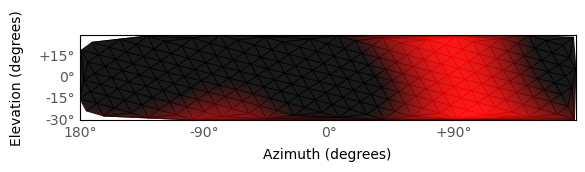

In [907]:
arg_lonticks = np.linspace(-180, 180, 5)
R = D.R
# Filter field to lie in specified interval
_, R_lat, R_lon = transform.cart2eq(*R)
_, R_lon_d = wrapped_rad2deg(R_lat, R_lon)
min_lon, max_lon = arg_lonticks.min(), arg_lonticks.max()
mask_lon = (min_lon <= R_lon_d) & (R_lon_d <= max_lon)
R_field = transform.eq2cart(1, R_lat[mask_lon], R_lon[mask_lon])
I_rgb = I[3,mask_lon]
print(I_rgb)
fig, ax = draw_map(I_rgb, R_field,
                   lon_ticks=arg_lonticks,
                   catalog=None,
                   show_labels=True,
                   show_axis=True)

In [483]:
I_rgb.shape
S.shape

(2521, 32, 32)

In [912]:
# Plot of predicted field with optimized model
# print(S[10, :, :])
I_rgb_pred = model(torch.from_numpy(S[3, :, :]).unsqueeze(0))
print(I_rgb_pred)
I_rgb_pred = I_rgb_pred.detach().numpy()[0,:]
print(I_rgb_pred.shape)
print(type(I_rgb_pred[0]))
fig, ax = draw_map(I_rgb_pred, R_field,
                   lon_ticks=arg_lonticks,
                   catalog=None,
                   show_labels=True,
                   show_axis=True)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0207,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

TypeError: numpy() got an unexpected keyword argument 'dtype'

In [157]:
# from torchsummary import summary
# summary(model, (30, 48, 48))

In [299]:
np.save("./cartesian_grid.npy", D.R)

## Simple & single inference

In [336]:
# Initialize a DeepWave Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deepwave = DeepWave(R=np.load("./cartesian_grid.npy"), kernel_size=K,Nch=Nch, Npx=Npx,
                 I_init=None, batch_size=256, depth=5).to(device)
print(deepwave)

DeepWave(
  (y_backproj): BackProjLayer()
  (enc_l4): SphericalConvLayer(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
  )
  (enc_l3): SphericalConvLayer(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
  )
  (enc_l2): SphericalConvLayer(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
  )
  (enc_l1): SphericalConvLayer(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
  )
  (enc_l0): SphericalConvLayer(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
  )
)


/var/folders/sz/blc6r8d1325glpsgy907r1dr0000gn/T/ipykernel_52001/3990177747.py:137: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Ln = (2 / D_max[0]) * G.L - sp.identity(W.shape[0], dtype=np.float, format='csc')


In [338]:
print(SS.shape)

torch.Size([2521, 32, 32])


In [342]:
# Initialize a DeepWave Model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
K=19
Nch, Npx = 32, 242
batch_size=256

SS = torch.rand((batch_size, 32, 32), dtype=torch.complex128)
print(np.load("cartesian_grid.npy").shape)
deepwave = DeepWave(R=np.load("cartesian_grid.npy"), kernel_size=K, Nch=Nch, Npx=Npx,
                 I_init=None, batch_size=batch_size, depth=5)
print(deepwave)

deepwave(SS)

(3, 242)


/var/folders/sz/blc6r8d1325glpsgy907r1dr0000gn/T/ipykernel_52001/3990177747.py:137: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Ln = (2 / D_max[0]) * G.L - sp.identity(W.shape[0], dtype=np.float, format='csc')


DeepWave(
  (y_backproj): BackProjLayer()
  (enc_l4): SphericalConvLayer(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
  )
  (enc_l3): SphericalConvLayer(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
  )
  (enc_l2): SphericalConvLayer(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
  )
  (enc_l1): SphericalConvLayer(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
  )
  (enc_l0): SphericalConvLayer(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
  )
)


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.8865,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)

In [303]:
# Simple prediction with a randomized visibility matrix SS (correlation matrix)
SS = torch.rand((1, 32, 32), dtype=torch.complex128) # NOTE: needs to be complex valued
pred = model(SS)
print(pred)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ReluBackward0>)


## Reference src code for chev filter implementation

Commented code below as its irrelevant with the respect to the above implementation. Only kept as a source of truth reference!

In [ ]:
# def cheb_conv(laplacian, inputs, weight):
#     """Chebyshev convolution.
#     Args:
#         laplacian (:obj:`torch.sparse.Tensor`): The laplacian corresponding to the current sampling of the sphere.
#         inputs (:obj:`torch.Tensor`): The current input data being forwarded.
#         weight (:obj:`torch.Tensor`): The weights of the current layer.
#     Returns:
#         :obj:`torch.Tensor`: Inputs after applying Chebyshev convolution.
#     """
#     print(inputs.shape)
#     print(weight.shape)
#     B, V = inputs.shape
#     K, Fin, Fout = weight.shape
#     # B = batch size
#     # V = nb vertices
#     # Fin = nb input features
#     # Fout = nb output features
#     # K = order of Chebyshev polynomials
#     # transform to Chebyshev basis
#     print("Input shape", inputs.shape)
#     x0 = inputs.permute(1, 2, 0).contiguous()  # V x Fin x B
#     x0 = x0.view([V, Fin * B])  # V x Fin*B
#     print("x00 shapes", x0.shape)
#     inputs = x0.unsqueeze(0)  # 1 x V x Fin*B

#     if K > 0:
#         x1 = torch.sparse.mm(laplacian, x0)  # V x Fin*B
#         inputs = torch.cat((inputs, x1.unsqueeze(0)), 0)  # 2 x V x Fin*B
#         for _ in range(1, K - 1):
#             x2 = 2 * torch.sparse.mm(laplacian, x1) - x0
#             inputs = torch.cat((inputs, x2.unsqueeze(0)), 0)  # M x Fin*B
#             x0, x1 = x1, x2

#     inputs = inputs.view([K, V, Fin, B])  # K x V x Fin x B
#     inputs = inputs.permute(3, 1, 2, 0).contiguous()  # B x V x Fin x K
#     inputs = inputs.view([B * V, Fin * K])  # B*V x Fin*K

#     # Linearly compose Fin features to get Fout features
#     weight = weight.view(Fin * K, Fout)
#     inputs = inputs.matmul(weight)  # B*V x Fout
#     inputs = inputs.view([B, V, Fout])  # B x V x Fout

#     return inputs

# class ChebConv(torch.nn.Module):
#     """Graph convolutional layer.
#     """

#     def __init__(self, in_channels, out_channels, kernel_size, bias=True, conv=cheb_conv):
#         """Initialize the Chebyshev layer.
#         Args:
#             in_channels (int): Number of channels/features in the input graph.
#             out_channels (int): Number of channels/features in the output graph.
#             kernel_size (int): Number of trainable parameters per filter, which is also the size of the convolutional kernel.
#                                 The order of the Chebyshev polynomials is kernel_size - 1.
#             bias (bool): Whether to add a bias term.
#             conv (callable): Function which will perform the actual convolution.
#         """
#         super().__init__()

#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.kernel_size = kernel_size
#         self._conv = conv

#         shape = (kernel_size, in_channels, out_channels)
#         self.weight = torch.nn.Parameter(torch.Tensor(*shape))

#         if bias:
#             self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
#         else:
#             self.register_parameter("bias", None)

#         self.kaiming_initialization()

#     def kaiming_initialization(self):
#         """Initialize weights and bias.
#         """
#         std = math.sqrt(2 / (self.in_channels * self.kernel_size))
#         self.weight.data.normal_(0, std)
#         if self.bias is not None:
#             self.bias.data.fill_(0.01)

#     def forward(self, laplacian, inputs):
#         """Forward graph convolution.
#         Args:
#             laplacian (:obj:`torch.sparse.Tensor`): The laplacian corresponding to the current sampling of the sphere.
#             inputs (:obj:`torch.Tensor`): The current input data being forwarded.
#         Returns:
#             :obj:`torch.Tensor`: The convoluted inputs.
#         """
#         outputs = self._conv(laplacian, inputs, self.weight)
#         if self.bias is not None:
#             outputs += self.bias
#         return outputs
    
# class SphericalChebConv(torch.nn.Module):
#     """Building Block with a Chebyshev Convolution.
#     """

#     def __init__(self, in_channels, out_channels, lap, kernel_size):
#         """Initialization.
#         Args:
#             in_channels (int): initial number of channels
#             out_channels (int): output number of channels
#             lap (:obj:`torch.sparse.FloatTensor`): laplacian
#             kernel_size (int): polynomial degree. Defaults to 3.
#         """
#         super().__init__()
#         self.register_buffer("laplacian", lap)
#         self.chebconv = ChebConv(in_channels, out_channels, kernel_size)

#     def state_dict(self, *args, **kwargs):
#         """! WARNING !
#         This function overrides the state dict in order to be able to save the model.
#         This can be removed as soon as saving sparse matrices has been added to Pytorch.
#         """
#         state_dict = super().state_dict(*args, **kwargs)
#         del_keys = []
#         for key in state_dict:
#             if key.endswith("laplacian"):
#                 del_keys.append(key)
#         for key in del_keys:
#             del state_dict[key]
#         return state_dict

#     def forward(self, x):
#         """Forward pass.
#         Args:
#             x (:obj:`torch.tensor`): input [batch x vertices x channels/features]
#         Returns:
#             :obj:`torch.tensor`: output [batch x vertices x channels/features]
#         """
#         x = self.chebconv(self.laplacian, x)
#         return x

In [ ]:
# TODO: 
# Compare and match the dimentions of the convolutional layer we are using in Torch vs Numpy
